In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

import os   
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

pd.options.display.max_columns = 60

## Data

In [0]:
def load_data():
    data = pd.read_csv('survey.csv')
    data.drop(columns='Informazioni cronologiche', inplace=True)

    oldcols = data.columns

    data.dropna(inplace=True)
    df = pd.DataFrame()
    for n,i in enumerate(data.columns):
        df['ans_' + str(n)] = pd.Categorical(data[i]).codes

    df['ans_0'] = df['ans_0'].apply(lambda x: None if x==2 else x)
    df.dropna(inplace=True)

    cols = ['ans_' + str(i) for i in range(2,9)]
    for i in cols:
        df[i] = df[i] + 1
    eng = df.loc[df['ans_0']==0].sample(len(df.loc[df['ans_0']==1]))
    ita = df.loc[df['ans_0']==1]
    balanced_df_ = pd.concat([ita,eng])
    return balanced_df_


In [0]:
def dummy(dataframe):
    cols = list(dataframe.columns)
    cols.remove('ans_0')
    cols.remove('ans_1')
    tmp = pd.DataFrame(dataframe['ans_0'])
            
    for i in cols:
        tmp = tmp.join(pd.get_dummies(dataframe[i], prefix=i))
    
    return tmp

In [0]:
def split_df(dataframe):
    if 'ans_0' in dataframe.columns:
        x = dataframe.drop(columns=['ans_0'])
        y = dataframe['ans_0']
    else:
        raise 'Mehnhhm'
    if 'ans_1' in dataframe.columns:
        x.drop(columns=['ans_1'], inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=45)
    return x, y, x_train, x_test, y_train, y_test

In [0]:
def plot_ans(dataframe):
    fig, axis = plt.subplots(2,4,figsize=(30,16))
    for i in range(8):
        if i % 2 == 0:
            k = 1
            j = i//2
        else:
            k = 0
            j = (i - 1)//2
            
        sns.boxenplot(x='ans_0', y='ans_{}'.format(i+2), data=dataframe, ax=axis[k, j])
        axis[k,j].set_title(oldcols[i+2][:17])
        axis[k,j].set_ylim(1,5)
        axis[k,j].set_xticklabels(['Inglesi', 'Italiani'], fontsize=14)
        axis[k,j].set_yticks(range(1,6))
        axis[k,j].set_xlabel('Nazionalità')
        axis[k,j].set_ylabel('Level of Offence')
        axis[k,j].tick_params(bottom=False, left=False)
        sns.despine(left=True, bottom=True)

## Anova

In [0]:
def anova(dataframe):
    italians = dataframe.loc[dataframe['ans_0'] == 1].drop(columns=['ans_0', 'ans_1']).mean(axis=1)
    english = dataframe.loc[dataframe['ans_0'] == 0].drop(columns=['ans_0', 'ans_1']).sample(len(italians)).mean(axis=1)
    return stats.f_oneway(italians, english)

## Logistic Regression

In [0]:
def logmodel(x_train, y_train, x_test, y_test):
    lr = LogisticRegression( solver='lbfgs', multi_class='auto')
    lr.fit(x_train, y_train)

    predictions = lr.predict(x_test)
    return (accuracy_score(y_test, predictions), confusion_matrix(y_test, predictions))

## K-Nearest Neighbours

In [0]:
def knnmodel(x_train, y_train, x_test, y_test):
    neigh = RadiusNeighborsClassifier(radius=3.0)
    neigh.fit(x_train, y_train)
    results = neigh.predict(x_test)
    return (accuracy_score(y_test, results),confusion_matrix(y_test, results))

## Neural Net

In [0]:
def create_model():
    input_layer = layers.Input(shape=(40))

    x = layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(input_layer)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(8, kernel_regularizer=regularizers.l2(0.0001),
                    activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(input_layer, output)


    model.compile(loss='binary_crossentropy',
              optimizer=('adam'),
              metrics=['acc']) 
    return model

In [0]:
def train_and_eval(model, xtrain, ytrain, xtest, ytest, islast=False):
    model.fit(
            x = xtrain,
            steps_per_epoch=100,  
            epochs=20,
            y=ytrain,
            verbose=0)
    return model.evaluate(xtest, ytest)


def evaluate_model(model, x,y):
    hist = model.fit(
                    x = x,
                    steps_per_epoch=99,  
                    epochs=100,
                    y=y,
                    validation_split=0.3,
                    validation_steps=33)
    return hist


In [0]:
def plot_model(history):
    # Retrieve a list of accuracy results on training and validation data
    # sets for each training epoch
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    # Retrieve a list of list results on training and validation data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')

In [0]:
def run_model():
        n_folds = 2
        data = load_data()
        dummy_df = dummy(data)
        x, y, _, _, _, _ = split_df(dummy_df)
        skf = StratifiedKFold(n_folds, shuffle=True)
        mean_score = []
        for train, test in skf.split(x,y):
                model = None # Clearing the NN.
                model = create_model()
                results = train_and_eval(model, 
                                            x.loc[train].dropna(), 
                                            y.loc[train].dropna(), 
                                            x.loc[test].dropna(), 
                                            y.loc[test].dropna())
                print(results)
                mean_score.append(results[1])
        print("Mean accuracy: ", np.mean(mean_score))
        model = None # Clearing the NN.
        model = create_model()
        histor = evaluate_model(model, x, y)
        plot_model(histor)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/p

69/69 [==============================] - 0s 4ms/sample - loss: 8.7244 - acc: 0.7826
[8.724436071039975, 0.7826087]
73/73 [==============================] - 0s 4ms/sample - loss: 11.3838 - acc: 0.7808
[11.383778505129357, 0.7808219]
Mean accuracy:  0.7817153
Train on 99 samples, validate on 96 samples
Epoch 1/100
99/99 [==============================] - 2s 17ms/step - loss: 0.6519 - acc: 0.7020 - val_loss: 0.9601 - val_acc: 0.0000e+00
Epoch 2/100
99/99 [==============================] - 0s 5ms/step - loss: 0.6157 - acc: 0.7128 - val_loss: 1.0570 - val_acc: 0.0000e+00
Epoch 3/100
99/99 [==============================] - 0s 5ms/step - loss: 0.5927 - acc: 0.7141 - val_loss: 1.0565 - val_acc: 0.0000e+00
Epoch 4/100
99/99 [==============================] - 0s 5ms/step - loss: 0.5616 - acc: 0.7142 - val_loss: 1.1281 - val_acc: 0.0000e+00
Epoch 5/100
99/99 [==============================] - 0s 5ms/step - loss: 0.5204 - acc: 0.7143 - val_loss: 1.4477 - val_acc: 0.0000e+00
Epoch 6/100
99/99 [===

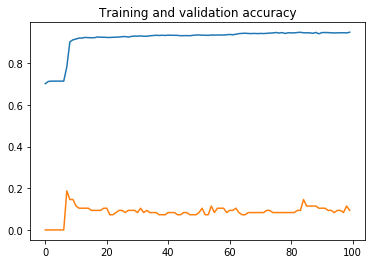

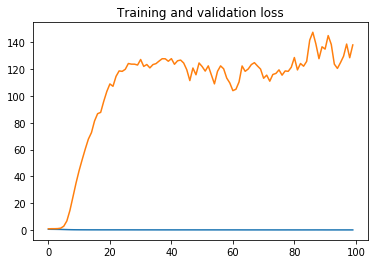

In [0]:
run_model()